# **Importing libraries**

In [33]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from wordcloud import WordCloud

from matplotlib import pyplot as plt

In [ ]:
#library imports
import torch
import torch.nn as nn

import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error


# **Loading data**

In [2]:
def loader(file, is_number = False):
    data = []
    with open(file, encoding="utf8") as my_file:
        data = my_file.read().splitlines()
    if is_number:
        data = [int(i) for i in data]
    return data

In [3]:
test_data = loader("data/test_text.txt")
test_labels = loader("data/test_labels.txt", True)
val_data = loader("data/val_text.txt")
val_labels = loader("data/val_labels.txt", True)
train_data = loader("data/train_text.txt")
train_labels = loader("data/train_labels.txt", True)
mappings = {0:"anger", 1:"joy", 2:"optimism",3:	"sadness"}

In [8]:
test = pd.DataFrame({"text":test_data, "label":test_labels, "emotion":[mappings[i] for i in test_labels]})
valid = pd.DataFrame({"text":val_data, "label":val_labels, "emotion":[mappings[i] for i in val_labels]})
train = pd.DataFrame({"text":train_data, "label":train_labels, "emotion":[mappings[i] for i in train_labels]})

In [10]:
train.head()

,text,label,emotion
0,“Worry is a down payment on a problem you may ...,2,optimism
1,My roommate: it's okay that we can't spell bec...,0,anger
2,No but that's so cute. Atsu was probably shy a...,1,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger
4,it's pretty depressing when u hit pan on ur fa...,3,sadness


In [9]:
test.head()

,text,label,emotion
0,#Deppression is real. Partners w/ #depressed p...,3,sadness
1,@user Interesting choice of words... Are you c...,0,anger
2,My visit to hospital for care triggered #traum...,3,sadness
3,@user Welcome to #MPSVT! We are delighted to h...,1,joy
4,What makes you feel #joyful?,1,joy


In [11]:
valid.head()

,text,label,emotion
0,"@user @user Oh, hidden revenge and anger...I r...",0,anger
1,if not then #teamchristine bc all tana has don...,0,anger
2,Hey @user #Fields in #skibbereen give your onl...,0,anger
3,Why have #Emmerdale had to rob #robron of havi...,0,anger
4,@user I would like to hear a podcast of you go...,0,anger


# **Exploratory data analysis**

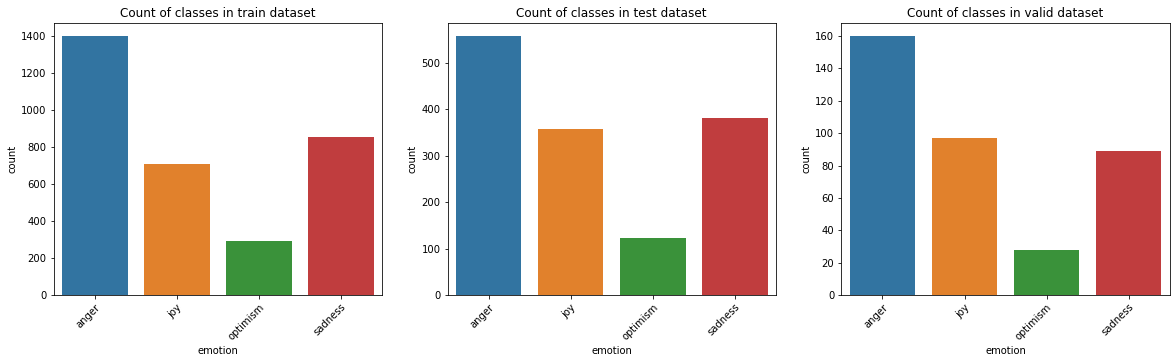

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

sns.countplot(data=train.sort_values(by=["emotion"]), x="emotion", ax = ax[0])
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sns.countplot(data=test.sort_values(by=["emotion"]), x="emotion", ax = ax[1])
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sns.countplot(data=valid.sort_values(by=["emotion"]), x="emotion", ax = ax[2])
plt.setp(ax[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax[0].set_title("Count of classes in train dataset")
ax[1].set_title("Count of classes in test dataset")
ax[2].set_title("Count of classes in valid dataset")

plt.show()

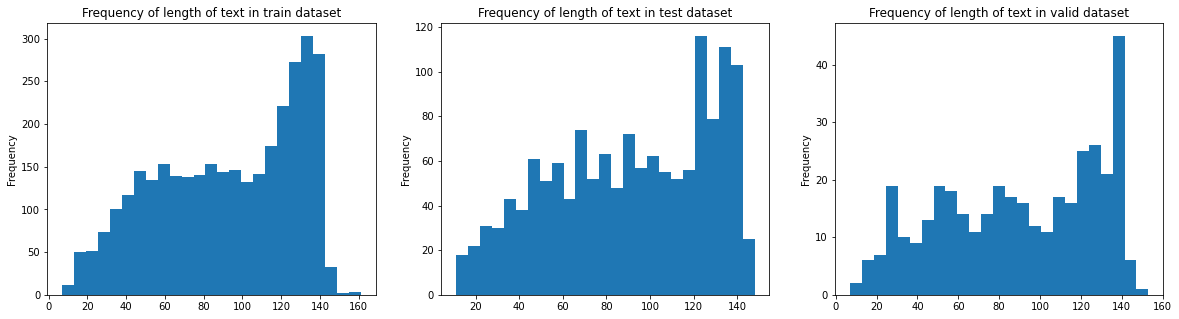

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

train["text"].apply(lambda s : len(s)).plot.hist(bins=25, ax=ax[0])
test["text"].apply(lambda s : len(s)).plot.hist(bins=25, ax=ax[1])
valid["text"].apply(lambda s : len(s)).plot.hist(bins=25, ax=ax[2])

ax[0].set_title("Frequency of length of text in train dataset")
ax[1].set_title("Frequency of length of text in test dataset")
ax[2].set_title("Frequency of length of text in valid dataset")

plt.show()

In [76]:
from collections import Counter

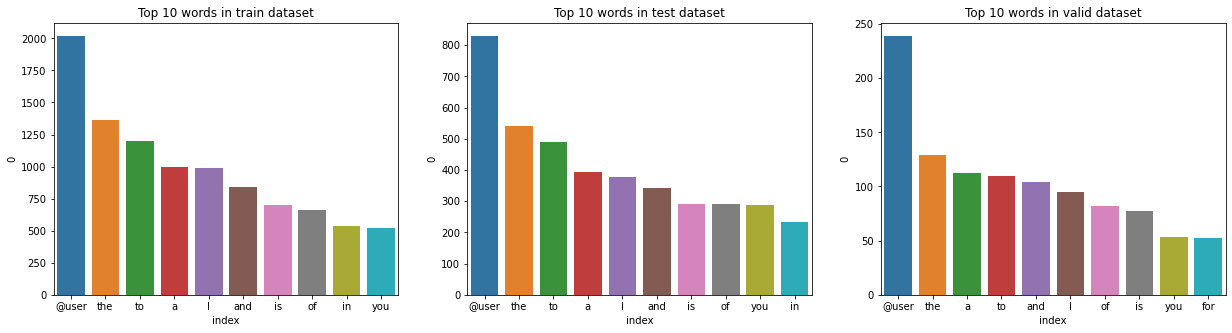

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,5))

sns.barplot(
    x = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in train["text"]]).split()).most_common(10)), orient="index").reset_index()["index"],
    y = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in train["text"]]).split()).most_common(10)), orient="index").reset_index()[0],
    ax = ax[0]
)

sns.barplot(
    x = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in test["text"]]).split()).most_common(10)), orient="index").reset_index()["index"],
    y = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in test["text"]]).split()).most_common(10)), orient="index").reset_index()[0],
    ax = ax[1]
)

sns.barplot(
    x = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in valid["text"]]).split()).most_common(10)), orient="index").reset_index()["index"],
    y = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in valid["text"]]).split()).most_common(10)), orient="index").reset_index()[0],
    ax = ax[2]
)

ax[0].set_title("Top 10 words in train dataset")
ax[1].set_title("Top 10 words in test dataset")
ax[2].set_title("Top 10 words in valid dataset")

plt.show()

# **Cleaning the data**

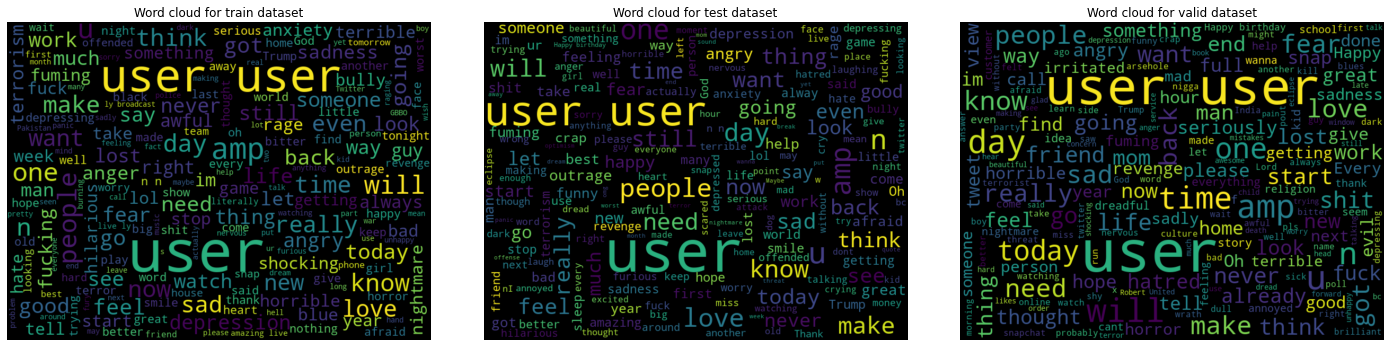

In [121]:
train_words = ' '.join([text for text in train["text"]])
test_words  = ' '.join([text for text in test["text"]])
valid_words = ' '.join([text for text in valid["text"]])


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
plt.tight_layout()

train_wc = WordCloud(width=800, height=600, random_state=21, max_font_size=110).generate(train_words)
test_wc = WordCloud(width=800, height=600, random_state=21, max_font_size=110).generate(test_words)
valid_wc = WordCloud(width=800, height=600, random_state=21, max_font_size=110).generate(valid_words)

ax[0].imshow(train_wc, interpolation="bilinear")
ax[0].axis('off')
ax[0].set_title("Word cloud for train dataset")

ax[1].imshow(test_wc, interpolation="bilinear")
ax[1].axis('off')
ax[1].set_title("Word cloud for test dataset")

ax[2].imshow(valid_wc, interpolation="bilinear")
ax[2].axis('off')
ax[2].set_title("Word cloud for valid dataset")

plt.show()

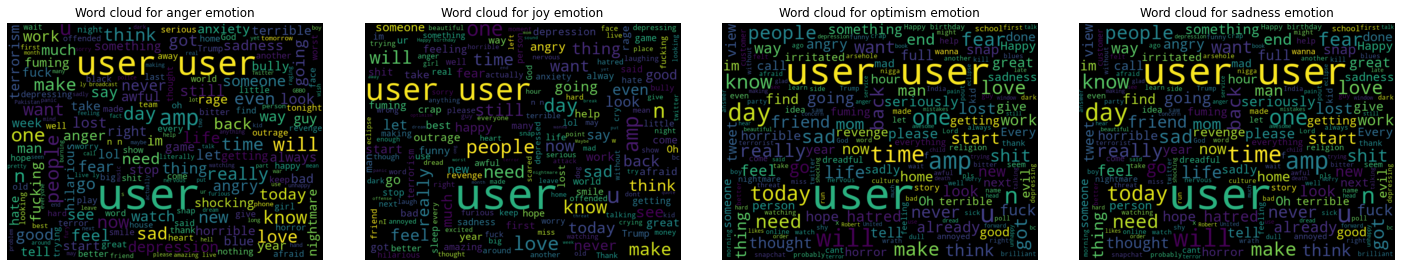

In [122]:
anger_words = ' '.join(train[train["emotion"] == "anger"]["text"])
joy_words  = ' '.join(train[train["emotion"] == "joy"]["text"])
optimism_words = ' '.join(train[train["emotion"] == "optimism"]["text"])
sadness_words = ' '.join(train[train["emotion"] == "sadness"]["text"])

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
plt.tight_layout()

anger_wc = WordCloud(width=600, height=600, random_state=21, max_font_size=110).generate(anger_words)
joy_wc = WordCloud(width=600, height=600, random_state=21, max_font_size=110).generate(joy_words)
optimism_wc = WordCloud(width=600, height=600, random_state=21, max_font_size=110).generate(optimism_words)
sadness_wc = WordCloud(width=600, height=600, random_state=21, max_font_size=110).generate(sadness_words)

ax[0].imshow(train_wc, interpolation="bilinear")
ax[0].axis('off')
ax[0].set_title("Word cloud for anger emotion")

ax[1].imshow(test_wc, interpolation="bilinear")
ax[1].axis('off')
ax[1].set_title("Word cloud for joy emotion")

ax[2].imshow(valid_wc, interpolation="bilinear")
ax[2].axis('off')
ax[2].set_title("Word cloud for optimism emotion")

ax[3].imshow(valid_wc, interpolation="bilinear")
ax[3].axis('off')
ax[3].set_title("Word cloud for sadness emotion")

plt.show()

In [ ]:
#tokenization
tok = spacy.load("en_core_web_sm")
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
#count number of occurences of each word
counts = Counter()
for index, row in emotions.iterrows():
    counts.update(tokenize(row["text"]))

In [ ]:
counts.most_common(10)

In [ ]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

In [ ]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
emotions["encoded"] = emotions["text"].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
emotions.head()

In [ ]:
ax = sns.countplot(x="emotion", data=emotions)
ax.set_title("Value count of each label")
plt.show()

In [ ]:
X = list(emotions["encoded"])
y = list(emotions["target"])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

#### Pytorch Dataset

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [ ]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

### LSTM with fixed length input

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)

In [ ]:
train_model(model_fixed, epochs=30, lr=0.01)

In [ ]:
train_model(model_fixed, epochs=30, lr=0.01)

In [ ]:
train_model(model_fixed, epochs=30, lr=0.01)

### LSTM with variable length input

In [ ]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [ ]:
model = LSTM_variable_input(vocab_size, 50, 50)

In [ ]:
train_model(model, epochs=30, lr=0.1)

In [ ]:
train_model(model, epochs=30, lr=0.05)

In [ ]:
train_model(model, epochs=30, lr=0.05)